<a href="https://colab.research.google.com/github/marsggbo/AutoMLDemos/blob/main/ch7/ResNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies and Import Modules

You shoud **restart/rerun** the runtime after running the following pip commands.

In [1]:
!pip install -U -q git+https://github.com/marsggbo/hyperbox.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 91.0 MB/s eta 0:00

In [2]:
import os

import torch
import torch.nn as nn
import torchvision

from torchvision import datasets, transforms

assert torch.cuda.is_available(), 'CUDA unavailable, invalid setup'

# Prepare CIFAR10 Datasets

In [3]:

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 128

DATAPATH = './data'
all_train_set = datasets.CIFAR10(root=DATAPATH, train=True, download=True, transform=train_transform)
length_set = len(all_train_set)
len_train_set = length_set // 2
len_val_set = length_set - len_train_set
train_set, val_set = torch.utils.data.random_split(all_train_set, [len_train_set, len_val_set])
test_set = datasets.CIFAR10(root=DATAPATH, train=False, download=True, transform=valid_transform)

print(f"length of train/val/test set: {len_train_set}/{len_val_set}/{len(test_set)}")

all_train_loader = torch.utils.data.DataLoader(all_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12800541.15it/s]


Extracting /home/xihe/datasets/cifar10/cifar-10-python.tar.gz to /home/xihe/datasets/cifar10
Files already downloaded and verified
length of train/val/test set: 25000/25000/10000


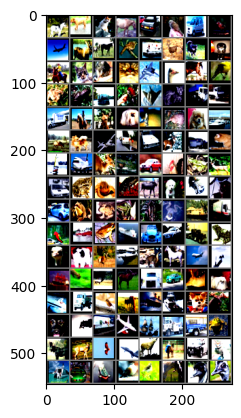

horse dog cat horse car bird car bird plane deer horse bird ship deer dog cat horse cat cat cat plane bird horse bird frog frog ship bird plane cat truck truck truck horse deer dog cat bird dog ship deer dog plane truck car deer truck cat ship plane deer deer car bird frog deer truck frog frog frog deer dog car cat car frog frog frog frog frog ship truck bird ship frog ship car car truck frog bird dog deer ship cat horse plane bird ship deer deer deer truck car deer dog ship truck bird horse ship ship dog deer dog cat truck plane ship truck truck frog deer deer bird plane deer horse car cat ship car ship bird bird horse bird bird


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:1s}' for j in range(batch_size)))

# Train & Test Function

In [5]:
def train(loader, network, mutator, criterion, w_opt, device, epoch):
    network.train()
    for batch_idx, (train_x, train_y) in enumerate(loader):
        train_x, train_y = train_x.to(device, non_blocking=True), train_y.to(device, non_blocking=True)

        # update weights
        w_opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            mutator.reset()
        output = network(train_x)
        w_loss = criterion(output, train_y)
        w_loss.backward()
        w_opt.step()

        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} tLoss: {:.6f}'.format(epoch, w_loss.item()))
        

In [6]:

def validate(loader, network, criterion, device, num_batches=None, mutator=None, verbose=True):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            if num_batches is not None and batch_idx >= num_batches:
                break
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            output = network(x)
            loss = criterion(output, y)
            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()
    test_loss /= len(loader.dataset)
    test_acc = 100. * correct / len(loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(loader.dataset), test_acc))
    return {'loss': test_loss, 'acc': test_acc}

# Define a Supernet & Mutator

In [7]:
from hyperbox.networks.resnet import resnet18
from hyperbox.mutator import EvolutionMutator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = resnet18(ratios=[0.5, 0.8, 1], num_classes=10).to(device)
mutator = EvolutionMutator(net)
mutator.reset()
print(mutator._cache)

{'layer4_outplanes1': tensor([ True, False, False]), 'layer1_inplanes': tensor([False,  True, False]), 'layer1_outplanes0': tensor([ True, False, False]), 'layer1_outplanes1': tensor([False, False,  True]), 'layer2_outplanes0': tensor([False,  True, False]), 'layer2_outplanes1': tensor([False,  True, False]), 'layer3_outplanes0': tensor([False,  True, False]), 'layer3_outplanes1': tensor([False, False,  True]), 'layer4_outplanes0': tensor([ True, False, False])}


# Pre-training Supernet

In [8]:
criterion = torch.nn.CrossEntropyLoss()
history = {}
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
network = net.to(device)
mutator = mutator.to(device)
w_opt = torch.optim.SGD(net.parameters(),  lr=0.01, momentum=0.9, weight_decay=5e-4)
train_epochs = 150
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(w_opt, T_max=train_epochs+20)
if os.path.exists('resnet18_supernet.pt'):
    network.load_state_dict(torch.load('resnet18_supernet.pt'))
    print("load pretrained supernet from resnet18_supernet.pt")
    train_epochs = 0
for epoch in range(train_epochs):
    train(train_loader, network, mutator, criterion, w_opt, device, epoch)
    mask = mutator.export()
    mutator.sample_by_mask(mask)
    results = validate(val_loader, network, criterion, device, verbose=True)
    val_loss, val_acc = results['loss'], results['acc']
    print(f"acc={val_acc} loss={val_loss}")
    torch.save(network.state_dict(), 'resnet18_supernet.pt')
    lr_scheduler.step()


Train Epoch: 0 tLoss: 2.015757

Test set: Average loss: 0.0281, Accuracy: 1120/10000 (11%)

acc=acc loss=loss
Train Epoch: 1 tLoss: 1.688079

Test set: Average loss: 0.0145, Accuracy: 3153/10000 (32%)

acc=acc loss=loss
Train Epoch: 2 tLoss: 1.823702

Test set: Average loss: 0.0152, Accuracy: 2986/10000 (30%)

acc=acc loss=loss
Train Epoch: 3 tLoss: 1.490918

Test set: Average loss: 0.0180, Accuracy: 3046/10000 (30%)

acc=acc loss=loss
Train Epoch: 4 tLoss: 1.589126

Test set: Average loss: 0.0213, Accuracy: 2231/10000 (22%)

acc=acc loss=loss
Train Epoch: 5 tLoss: 1.461970

Test set: Average loss: 0.0154, Accuracy: 3790/10000 (38%)

acc=acc loss=loss
Train Epoch: 6 tLoss: 1.095382

Test set: Average loss: 0.0109, Accuracy: 5046/10000 (50%)

acc=acc loss=loss
Train Epoch: 7 tLoss: 1.299382

Test set: Average loss: 0.0094, Accuracy: 5743/10000 (57%)

acc=acc loss=loss
Train Epoch: 8 tLoss: 1.186062

Test set: Average loss: 0.0230, Accuracy: 1899/10000 (19%)

acc=acc loss=loss
Train Epoc

# Search via Evolutionary Algorithm

[2023-06-01 13:04:44] [INFO] [/usr/local/lib/python3.10/dist-packages/hyperbox/mutator/evolution_mutator.py:139 (hyperbox.mutator.evolution_mutator)] 
        Evolution Mutator start searching for 20 epochs with parameters:
            - population_num: 20
            - selection_num: 16
            - corssover_num: 4
            - mutation_num: 4
            - random_num: 12
            - selection_alg: nsga2
            - crossover_prob: 0.3
            - mutation_prob: 0.3
        
[2023-06-01 13:04:44] [INFO] [/usr/local/lib/python3.10/dist-packages/hyperbox/mutator/evolution_mutator.py:218 (hyperbox.mutator.evolution_mutator)] random select ........
[2023-06-01 13:09:02] [INFO] [/usr/local/lib/python3.10/dist-packages/hyperbox/mutator/evolution_mutator.py:156 (hyperbox.mutator.evolution_mutator)] epoch = 0
[2023-06-01 13:09:02] [INFO] [/usr/local/lib/python3.10/dist-packages/hyperbox/mutator/evolution_mutator.py:304 (hyperbox.mutator.evolution_mutator)] update top-16 models......


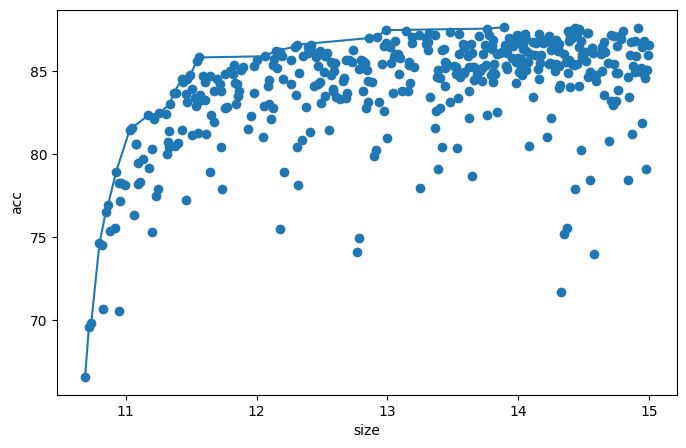

0: acc=87.664 loss=0.004071839307546616 size=13.889942169189453 flops=1197.540608
1: acc=66.548 loss=0.013266648516654968 size=10.6907958984375 flops=557.188352
2: acc=74.616 loss=0.009375688030719757 size=10.800521850585938 flops=673.518848
3: acc=87.488 loss=0.004265133989453316 size=12.985294342041016 flops=1117.541632
4: acc=78.956 loss=0.0076443668866157536 size=10.92816162109375 flops=773.14176
5: acc=86.48 loss=0.004548817762136459 size=12.290287017822266 flops=1090.462976
6: acc=82.124 loss=0.006162211011648178 size=11.220375061035156 flops=763.950336
7: acc=85.656 loss=0.004932184382081032 size=11.544151306152344 flops=982.787328
8: acc=84.344 loss=0.00544774134516716 size=11.440711975097656 flops=872.826112
9: acc=80.624 loss=0.006938351259231567 size=11.080089569091797 flops=935.011584


In [9]:
topk = mutator.search(
    warmup_epochs=0,
    evolution_epochs=20,
    population_num=20,
    selection_alg='nsga2',
    selection_num=0.8,
    crossover_num=0.2,
    crossover_prob=0.3,
    mutation_num=0.2,
    mutation_prob=0.3,
    topk=10,
    eval_func=validate,
    eval_kwargs={'loader': val_loader, 'criterion': nn.CrossEntropyLoss(),
                'device': device, 'num_batches': None, 'verbose': False},
    eval_metrics_order={'acc': 'max'},
    size_limit=15, # MB, the maximum size of a model
    log_dir='evolution_logs_<15MB',
    to_save_checkpoint=True,
    to_plot_pareto=True,
    figname='evolution_pareto.pdf',
)
for i, subnet_info in enumerate(topk):
    acc = subnet_info['performance']['acc']
    loss = subnet_info['performance']['loss']
    size = subnet_info['size']
    flops = subnet_info['flops']
    print(f"{i}: acc={acc} loss={loss} size={size} flops={flops}")

## Finetune the Exported Subnet

In [10]:

def finetune(train_loader, network, criterion, w_opt, device, epoch):
    network.train()
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x, train_y = train_x.to(device, non_blocking=True), train_y.to(device, non_blocking=True)

        # update weights
        w_opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            mutator.reset()
        output = network(train_x)
        w_loss = criterion(output, train_y)
        w_loss.backward()
        w_opt.step()

In [11]:
def finetune_subnet(topk, index, net, all_train_loader, test_loader, criterion, device, size_original, finetune_epochs=50):
    subnet = net.build_subnet(mask=topk[0]['arch']).to(device)
    w_opt = torch.optim.Adam(subnet.parameters(),  lr=0.0005, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(w_opt, T_max=finetune_epochs+20)
    best_val_acc = 0
    for epoch in range(finetune_epochs):
        finetune(all_train_loader, subnet, criterion, w_opt, device, epoch)
        results = validate(test_loader, subnet, criterion, device, verbose=False)
        val_loss, val_acc = results['loss'], results['acc']
        print(f"Epoch{epoch}: acc={val_acc} loss={val_loss}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(network.state_dict(), f'resnet18_subnet{index}.pt')
        lr_scheduler.step()
    size_subnet = sum([p.numel() for p in subnet.parameters()])
    print(size_original, size_subnet, f"compressed by {(1-size_subnet/size_original)*100}%.")


In [ ]:

size_original = sum([p.numel() for p in network.parameters()])
for i in range(len(topk)):
    print(f"finetune subnet {i}")
    finetune_subnet(topk, i, net, all_train_loader, test_loader, criterion, device, size_original)


finetune subnet 0
Epoch0: acc=82.17 loss=0.004415973809361458
Epoch1: acc=82.23 loss=0.004280365808308125
Epoch2: acc=85.42 loss=0.0035281834498047827
Epoch3: acc=84.1 loss=0.003896720510721207
Epoch4: acc=86.0 loss=0.003378988966345787
Epoch5: acc=82.88 loss=0.004343833720684052
Epoch6: acc=84.5 loss=0.003791753923892975
Epoch7: acc=87.61 loss=0.002974717192351818
Epoch8: acc=86.53 loss=0.003262543174624443
Epoch9: acc=87.39 loss=0.0029888041764497757
Epoch10: acc=88.38 loss=0.0029151264652609826
Epoch11: acc=87.69 loss=0.003037537942826748
Epoch12: acc=86.59 loss=0.0035508684381842614
Epoch13: acc=86.51 loss=0.00320487976372242
Epoch14: acc=87.51 loss=0.0031969469234347345
Epoch15: acc=87.15 loss=0.0033159261763095857
Epoch16: acc=87.73 loss=0.0030528542920947076
Epoch17: acc=85.99 loss=0.0038473331972956656
Epoch18: acc=88.55 loss=0.0029512146363034845
Epoch19: acc=88.63 loss=0.002839653092622757
Epoch20: acc=89.12 loss=0.002815436264872551
Epoch21: acc=88.87 loss=0.0030122516244649